In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft

In [ ]:


import matplotlib.pyplot as plt
import random
import re
import json
from PIL import Image
import requests

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights

from transformers import BertTokenizer, BertModel, logging as hf_logging
hf_logging.set_verbosity_error()

from datasets import load_dataset

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm.auto import tqdm
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

2025-05-23 09:42:36.309644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747993356.489494      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747993356.540824      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [ ]:

BATCH_SIZE = 16
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
TEXT_MODEL_NAME = 'bert-base-uncased'
PROJECTION_DIM = 512
NUM_EPOCHS = 20
MAX_TEXT_LENGTH = 128
VAL_SPLIT_RATIO = 0.15
RANDOM_SEED = 42


FOCAL_LOSS_ALPHA = 0.25
FOCAL_LOSS_GAMMA = 2.0


LABEL_SMOOTHING_EPSILON = 0.1


EARLY_STOPPING_PATIENCE = 5 
MIN_DELTA = 0.001


WARMUP_EPOCHS = 3
INITIAL_LR_RATIO = 0.01


torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)


try:
    full_dataset = load_dataset("sxj1215/mmimdb")
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e

print("\nDataset structure:")
print(full_dataset)

if 'train' not in full_dataset:
    print("Error: 'train' split not found in the dataset.")

else:
    dataset_split = full_dataset['train'].train_test_split(test_size=VAL_SPLIT_RATIO, shuffle=True, seed=RANDOM_SEED)
    train_hf_dataset = dataset_split['train']
    val_hf_dataset = dataset_split['test']
    print(f"\nUsing {len(train_hf_dataset)} samples for training.")
    print(f"Using {len(val_hf_dataset)} samples for validation.")


def extract_genres_from_sample(sample):
    try:
        assistant_message_content = sample['messages'][1]['content']
        genres = [genre.strip().lower() for genre in assistant_message_content.split(',')]
        return genres
    except (IndexError, TypeError, AttributeError):
        return []

all_genres_list = []
print("\nExtracting genres from dataset splits...")
print(f"Processing 'train' (original full) split with {len(full_dataset['train'])} items for genre extraction...")
for i in tqdm(range(len(full_dataset['train'])), desc="Extracting genres from full 'train' split"):
    item = full_dataset['train'][i]
    if not item.get('messages') or len(item['messages']) < 2 or \
       not item.get('images') or not item['images'][0]:
        continue
    genres = extract_genres_from_sample(item)
    if genres:
         all_genres_list.extend(genres)

unique_genres = sorted(list(set(all_genres_list)))
if not unique_genres:
    print("Warning: Dynamic genre extraction failed. Using a predefined list of genres.")
    predefined_genres_str = "drama, comedy, romance, thriller, crime, action, adventure, horror, documentary, mystery, sci-fi, fantasy, family, biography, war, history, music, animation, musical, western, sport, short, film-noir"
    unique_genres = sorted([g.strip().lower() for g in predefined_genres_str.split(',')])

mlb = MultiLabelBinarizer(classes=unique_genres)
mlb.fit([unique_genres])

NUM_CLASSES = len(mlb.classes_)
print(f"\nFound {NUM_CLASSES} unique genres: {mlb.classes_}")

genre_to_id = {genre: i for i, genre in enumerate(mlb.classes_)}
id_to_genre = {i: genre for i, genre in enumerate(mlb.classes_)}

if 'train_hf_dataset' not in locals() or 'val_hf_dataset' not in locals():
    print("\nWarning: 'train_hf_dataset' or 'val_hf_dataset' is not defined. This might happen if the 'train' split was not found in 'full_dataset'.")
    print("Further cells relying on these datasets might fail.")

README.md:   0%|          | 0.00/396 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/530M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/563M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/529M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15552 [00:00<?, ? examples/s]

Dataset loaded successfully.

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['messages', 'images'],
        num_rows: 15552
    })
})

Using 13219 samples for training.
Using 2333 samples for validation.

Extracting genres from dataset splits...
Processing 'train' (original full) split with 15552 items for genre extraction...


Extracting genres from full 'train' split:   0%|          | 0/15552 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS 


Found 26 unique genres: ['action' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy' 'film-noir' 'history' 'horror'
 'music' 'musical' 'mystery' 'news' 'reality-tv' 'romance' 'sci-fi'
 'short' 'sport' 'talk-show' 'thriller' 'war' 'western']


In [ ]:

import torch.nn.functional as F
IMG_SIZE=224
def extract_plot_text(messages):
    try:
        user_message_content = messages[0]['content']
        plot_match = re.search(r"Plot:\s*(.*?)\s*\nNote that a movie", user_message_content, re.DOTALL)
        if plot_match:
            return plot_match.group(1).strip()
    except (IndexError, TypeError, AttributeError):
        pass
    return "No plot found."

tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL_NAME)

def preprocess_text(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=MAX_TEXT_LENGTH, padding="max_length", truncation=True)
    return inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0)


image_transform_train = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    T.RandomRotation(degrees=20),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_transform_val = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image_with_transform(image_pil, transform):
    if image_pil is None:
        return torch.zeros((3, IMG_SIZE, IMG_SIZE))
    if image_pil.mode != 'RGB':
        image_pil = image_pil.convert('RGB')
    return transform(image_pil)

In [ ]:

class MMIMDbDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, image_transform,
                 text_preprocessor_fn, plot_extractor_fn, genre_extractor_fn, label_binarizer):
        self.hf_dataset = hf_dataset
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.text_preprocessor_fn = text_preprocessor_fn
        self.plot_extractor_fn = plot_extractor_fn
        self.genre_extractor_fn = genre_extractor_fn
        self.label_binarizer = label_binarizer

        self.valid_indices = []
        print("Filtering dataset for valid entries...")
        for i in tqdm(range(len(self.hf_dataset)), desc="Filtering dataset"):
            item = self.hf_dataset[i]
            if item.get('images') and len(item['images']) > 0 and item['images'][0] is not None and \
               item.get('messages') and len(item['messages']) > 1:
                     self.valid_indices.append(i)
        print(f"Found {len(self.valid_indices)} valid entries out of {len(self.hf_dataset)}.")


    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        item = self.hf_dataset[actual_idx]


        pil_image = item['images'][0]

        image_tensor = preprocess_image_with_transform(pil_image, self.image_transform)


        plot_text = self.plot_extractor_fn(item['messages'])
        input_ids, attention_mask = self.text_preprocessor_fn(plot_text)


        genres = self.genre_extractor_fn(item)
        if isinstance(genres, str): genres = [genres.strip().lower()]
        elif isinstance(genres, list): genres = [g.strip().lower() for g in genres]
        else: genres = []

        if not genres: genres = []

        try:
            labels_one_hot = self.label_binarizer.transform([genres])
            labels_tensor = torch.FloatTensor(labels_one_hot.squeeze())
        except ValueError as e:
            labels_tensor = torch.zeros(len(self.label_binarizer.classes_))


        return {
            "image": image_tensor,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels_tensor
        }


if 'train_hf_dataset' in locals() and 'val_hf_dataset' in locals():
    train_dataset = MMIMDbDataset(
        train_hf_dataset, tokenizer, image_transform_train,
        preprocess_text, extract_plot_text, extract_genres_from_sample, mlb
    )
    val_dataset = MMIMDbDataset(
        val_hf_dataset, tokenizer, image_transform_val,
        preprocess_text, extract_plot_text, extract_genres_from_sample, mlb
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True) 
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

    if len(train_dataset) > 0:
        print("\nTesting a sample from the DataLoader...")
        try:
            sample_batch = next(iter(train_loader))
            print("Image shape:", sample_batch["image"].shape)
            print("Input IDs shape:", sample_batch["input_ids"].shape)
            print("Labels shape:", sample_batch["labels"].shape)
            print("Sample loaded successfully.")
        except Exception as e:
            print(f"Error loading sample from DataLoader: {e}")
    else:
        print("Train dataset is empty after filtering. Cannot test DataLoader.")
else:
    print("Warning: train_hf_dataset or val_hf_dataset not defined. Skipping dataset instantiation.")

Filtering dataset for valid entries...


Filtering dataset:   0%|          | 0/13219 [00:00<?, ?it/s]

Found 13219 valid entries out of 13219.
Filtering dataset for valid entries...


Filtering dataset:   0%|          | 0/2333 [00:00<?, ?it/s]

Found 2333 valid entries out of 2333.

Testing a sample from the DataLoader...
Image shape: torch.Size([16, 3, 224, 224])
Input IDs shape: torch.Size([16, 128])
Labels shape: torch.Size([16, 26])
Sample loaded successfully.


In [ ]:


import torch.nn.functional as F

class SwiGLULayer(nn.Module):
    def __init__(self, in_features, out_features, hidden_features_explicit=None, bias=True, ffn_expansion_factor=8/3):
        super().__init__()
        if hidden_features_explicit is None:
            hidden_dim = int(in_features * ffn_expansion_factor)
        else:
            hidden_dim = hidden_features_explicit
        self.hidden_features = hidden_dim
        self.w1_gate = nn.Linear(in_features, hidden_dim, bias=bias)
        self.w3_value = nn.Linear(in_features, hidden_dim, bias=bias)
        self.w2_output = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        gate_proj = self.w1_gate(x)
        value_proj = self.w3_value(x)
        activated_hidden = F.silu(gate_proj) * value_proj
        output = self.w2_output(activated_hidden)
        return output

class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes, projection_dim=PROJECTION_DIM, text_model_name=TEXT_MODEL_NAME,
                 freeze_all_backbones=False, 
                 unfreeze_image_blocks=1,    
                 unfreeze_text_layers=2,     
                 ffn_expansion_factor=8/3,
                 dropout_rate=0.3):
        super(MultimodalClassifier, self).__init__()
        self.ffn_expansion_factor = ffn_expansion_factor

        self.image_backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.image_backbone.fc = nn.Identity()
        self.image_feature_dim = 2048

        self.text_backbone = BertModel.from_pretrained(text_model_name)
        self.text_feature_dim = self.text_backbone.config.hidden_size

        if freeze_all_backbones:
            print("Freezing all image and text backbone layers.")
            for param in self.image_backbone.parameters():
                param.requires_grad = False
            for param in self.text_backbone.parameters():
                param.requires_grad = False
        else:
            print("Fine-tuning backbones (partial or full unfreeze).")
            for param in self.image_backbone.parameters():
                param.requires_grad = False
            for param in self.text_backbone.parameters():
                param.requires_grad = False

            if unfreeze_image_blocks > 0:
                resnet_blocks_to_unfreeze = []
                if unfreeze_image_blocks >= 1: resnet_blocks_to_unfreeze.append(self.image_backbone.layer4)
                if unfreeze_image_blocks >= 2: resnet_blocks_to_unfreeze.append(self.image_backbone.layer3)
                if unfreeze_image_blocks >= 3: resnet_blocks_to_unfreeze.append(self.image_backbone.layer2)

                for block in resnet_blocks_to_unfreeze:
                    for param in block.parameters():
                        param.requires_grad = True
                print(f"Unfrozen last {len(resnet_blocks_to_unfreeze)} ResNet blocks.")
            else:
                print("All ResNet backbone layers (except projection) remain frozen.")


            if unfreeze_text_layers > 0:
                bert_encoder_layers = self.text_backbone.encoder.layer
                num_bert_layers_total = len(bert_encoder_layers)
                layers_to_unfreeze_count = min(unfreeze_text_layers, num_bert_layers_total)

                for i in range(num_bert_layers_total - layers_to_unfreeze_count, num_bert_layers_total):
                    for param in bert_encoder_layers[i].parameters():
                        param.requires_grad = True
                print(f"Unfrozen last {layers_to_unfreeze_count} BERT encoder layers.")

                if hasattr(self.text_backbone, 'pooler') and self.text_backbone.pooler is not None:
                    for param in self.text_backbone.pooler.parameters():
                        param.requires_grad = True
                    print("Unfrozen BERT pooler layer.")
            else:
                print("All BERT backbone layers (except projection) remain frozen.")
            
            for param in self.text_backbone.embeddings.parameters():
                 param.requires_grad = True
            print("Unfrozen BERT embedding layers.")


        self.image_projection = SwiGLULayer(
            in_features=self.image_feature_dim,
            out_features=projection_dim,
            ffn_expansion_factor=self.ffn_expansion_factor
        )
        self.text_projection = SwiGLULayer(
            in_features=self.text_feature_dim,
            out_features=projection_dim,
            ffn_expansion_factor=self.ffn_expansion_factor
        )

        fused_dim = projection_dim * 2

        self.self_attention = nn.MultiheadAttention(embed_dim=fused_dim, num_heads=8, batch_first=True, dropout=0.1)
        self.norm_after_attn = nn.LayerNorm(fused_dim)

        classifier_ffn_out_dim = fused_dim // 2
        self.classifier_ffn = SwiGLULayer(
            in_features=fused_dim,
            out_features=classifier_ffn_out_dim,
            ffn_expansion_factor=self.ffn_expansion_factor
        )
        self.classifier_output_layer = nn.Sequential(
            nn.LayerNorm(fused_dim),
            self.classifier_ffn,
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_ffn_out_dim, num_classes)
        )

    def forward(self, image_data, input_ids, attention_mask):
        image_features = self.image_backbone(image_data)
        projected_image_features = self.image_projection(image_features)

        text_outputs = self.text_backbone(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output
        projected_text_features = self.text_projection(text_features)

        fused_features = torch.cat((projected_image_features, projected_text_features), dim=1)

        attn_input = fused_features.unsqueeze(1)
        attn_output, _ = self.self_attention(attn_input, attn_input, attn_input)
        attn_output = attn_output.squeeze(1)
        attn_output = self.norm_after_attn(attn_output + fused_features)

        logits = self.classifier_output_layer(attn_output)
        return logits

if 'NUM_CLASSES' in locals():
    model = MultimodalClassifier(
        num_classes=NUM_CLASSES,
        freeze_all_backbones=False,     
        unfreeze_image_blocks=1,        
        unfreeze_text_layers=2,          
        dropout_rate=0.3
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel instantiated with FFN SwiGLU and partial unfreeze.")
    print(f"Image projection FFN hidden dim: {model.image_projection.hidden_features}")
    print(f"Text projection FFN hidden dim: {model.text_projection.hidden_features}")
    print(f"Classifier FFN hidden dim: {model.classifier_ffn.hidden_features}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    if not any(p.requires_grad for p in model.parameters()):
        print("\nWARNING: No parameters in the model are trainable.")
else:
    print("Warning: NUM_CLASSES not defined. Skipping model instantiation.")

Fine-tuning backbones (partial or full unfreeze).
Unfrozen last 1 ResNet blocks.
Unfrozen last 2 BERT encoder layers.
Unfrozen BERT pooler layer.
Unfrozen BERT embedding layers.

Model instantiated with FFN SwiGLU and partial unfreeze.
Image projection FFN hidden dim: 5461
Text projection FFN hidden dim: 2048
Classifier FFN hidden dim: 2730
Total parameters: 173,575,512
Trainable parameters: 94,153,496


In [ ]:


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        modulating_factor = torch.pow(1.0 - p_t, self.gamma)
        if isinstance(self.alpha, float):
            alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        else:
            alpha_factor = self.alpha.to(inputs.device) * targets + (1 - self.alpha.to(inputs.device)) * (1 - targets)
        focal_loss = alpha_factor * modulating_factor * BCE_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion = FocalLoss(alpha=FOCAL_LOSS_ALPHA, gamma=FOCAL_LOSS_GAMMA)
print(f"Using FocalLoss with alpha={FOCAL_LOSS_ALPHA}, gamma={FOCAL_LOSS_GAMMA}")

if 'model' in locals() and model is not None:

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    print(f"Optimizer AdamW set up with LR={LEARNING_RATE} and Weight Decay={WEIGHT_DECAY}.")
    print(f"Number of parameter groups in optimizer: {len(optimizer.param_groups)}")
    

    scheduler_factor = 0.2 
    scheduler_patience = 2
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='max',
                                                     factor=scheduler_factor,
                                                     patience=scheduler_patience,
                                                     verbose=True)
    print(f"Scheduler ReduceLROnPlateau set up with factor={scheduler_factor}, patience={scheduler_patience}.")
else:
    print("Warning: Model not defined. Optimizer and scheduler setup skipped. Ensure Cell 5 ran successfully.")


class EarlyStopping:
    def __init__(self, patience=EARLY_STOPPING_PATIENCE, min_delta=MIN_DELTA, verbose=False, path='best_multimodal_model_earlystop.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_metric_at_best_score = -np.Inf

    def __call__(self, val_metric, model):
        score = val_metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
            self.counter = 0

    def save_checkpoint(self, val_metric, model):
        if self.verbose:
            print(f'Validation metric improved ({self.val_metric_at_best_score:.6f} --> {val_metric:.6f}). Saving model to {self.path}')
        torch.save(model.state_dict(), self.path)
        self.val_metric_at_best_score = val_metric

if 'model' in locals() and model is not None:
    early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, min_delta=MIN_DELTA, verbose=True)
    print(f"Early stopping mechanism set up with patience={EARLY_STOPPING_PATIENCE} and min_delta={MIN_DELTA}.")
else:
    print("Warning: Model not defined. Early stopping setup skipped.")

Using FocalLoss with alpha=0.25, gamma=2.0
Optimizer AdamW set up with LR=0.0001 and Weight Decay=1e-05.
Number of parameter groups in optimizer: 1
Scheduler ReduceLROnPlateau set up with factor=0.2, patience=2.
Early stopping mechanism set up with patience=5 and min_delta=0.001.



Starting training for 20 epochs (3 warmup epochs)...

--- Epoch 1/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 1 - Current Learning Rate: 1.00e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (155520000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 1 Summary:
	Train Loss: 0.0464
	Val Loss  : 0.0252
	Macro-F1: 0.0000
	Micro-F1: 0.0000
	In warmup phase, LR managed by warmup logic. Main scheduler active from epoch 4.
Validation metric improved (-inf --> 0.000000). Saving model to best_multimodal_model_earlystop.pth

--- Epoch 2/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 2 - Current Learning Rate: 3.40e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94598713 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 Summary:
	Train Loss: 0.0257
	Val Loss  : 0.0173
	Macro-F1: 0.2803
	Micro-F1: 0.4600
	In warmup phase, LR managed by warmup logic. Main scheduler active from epoch 4.
Validation metric improved (0.000000 --> 0.280252). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.2803 (saved by EarlyStopping if improved)

--- Epoch 3/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 3 - Current Learning Rate: 6.70e-05


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 Summary:
	Train Loss: 0.0221
	Val Loss  : 0.0166
	Macro-F1: 0.3948
	Micro-F1: 0.5639
	In warmup phase, LR managed by warmup logic. Main scheduler active from epoch 4.
Validation metric improved (0.280252 --> 0.394760). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.3948 (saved by EarlyStopping if improved)

--- Epoch 4/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 4 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97888494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (91477452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 Summary:
	Train Loss: 0.0199
	Val Loss  : 0.0198
	Macro-F1: 0.3324
	Micro-F1: 0.5029
EarlyStopping counter: 1 out of 5

--- Epoch 5/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 5 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94770000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97965244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 Summary:
	Train Loss: 0.0175
	Val Loss  : 0.0193
	Macro-F1: 0.4188
	Micro-F1: 0.5907
Validation metric improved (0.394760 --> 0.418814). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.4188 (saved by EarlyStopping if improved)

--- Epoch 6/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 6 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/l

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
           ^ ^ ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/usr/lib/pytho

Epoch 6 Summary:
	Train Loss: 0.0156
	Val Loss  : 0.0225
	Macro-F1: 0.4739
	Micro-F1: 0.6155
Validation metric improved (0.418814 --> 0.473854). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.4739 (saved by EarlyStopping if improved)

--- Epoch 7/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 7 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (155520000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97888494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 Summary:
	Train Loss: 0.0141
	Val Loss  : 0.0242
	Macro-F1: 0.4632
	Micro-F1: 0.6079
EarlyStopping counter: 1 out of 5

--- Epoch 8/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 8 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97965244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97888494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS 

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 Summary:
	Train Loss: 0.0126
	Val Loss  : 0.0281
	Macro-F1: 0.4792
	Micro-F1: 0.6221
Validation metric improved (0.473854 --> 0.479246). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.4792 (saved by EarlyStopping if improved)

--- Epoch 9/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 9 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97212000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/lo

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 Summary:
	Train Loss: 0.0112
	Val Loss  : 0.0338
	Macro-F1: 0.4727
	Micro-F1: 0.6112
EarlyStopping counter: 1 out of 5

--- Epoch 10/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 10 - Current Learning Rate: 1.00e-04


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^

AssertionError:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
can o

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 Summary:
	Train Loss: 0.0102
	Val Loss  : 0.0360
	Macro-F1: 0.4630
	Micro-F1: 0.6216
EarlyStopping counter: 2 out of 5

--- Epoch 11/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 11 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97212000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 Summary:
	Train Loss: 0.0093
	Val Loss  : 0.0407
	Macro-F1: 0.4803
	Micro-F1: 0.6142
Validation metric improved (0.479246 --> 0.480251). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.4803 (saved by EarlyStopping if improved)

--- Epoch 12/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 12 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94770000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (124580321 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 Summary:
	Train Loss: 0.0084
	Val Loss  : 0.0451
	Macro-F1: 0.4960
	Micro-F1: 0.6305
Validation metric improved (0.480251 --> 0.496048). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.4960 (saved by EarlyStopping if improved)

--- Epoch 13/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 13 - Current Learning Rate: 1.00e-04


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
     ^^ ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^^if w.is_alive():^
^^ ^ ^ ^  ^ ^ ^^^^^^^^

Epoch 13 Summary:
	Train Loss: 0.0079
	Val Loss  : 0.0492
	Macro-F1: 0.4804
	Micro-F1: 0.6264
EarlyStopping counter: 1 out of 5

--- Epoch 14/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 14 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (92807532 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97212000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS 

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 Summary:
	Train Loss: 0.0076
	Val Loss  : 0.0523
	Macro-F1: 0.4893
	Micro-F1: 0.6260
EarlyStopping counter: 2 out of 5

--- Epoch 15/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 15 - Current Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97212000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97965244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS 

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 Summary:
	Train Loss: 0.0070
	Val Loss  : 0.0604
	Macro-F1: 0.4911
	Micro-F1: 0.6314
EarlyStopping counter: 3 out of 5

--- Epoch 16/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 16 - Current Learning Rate: 2.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97965244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94598713 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 Summary:
	Train Loss: 0.0055
	Val Loss  : 0.0634
	Macro-F1: 0.5104
	Micro-F1: 0.6423
Validation metric improved (0.496048 --> 0.510419). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.5104 (saved by EarlyStopping if improved)

--- Epoch 17/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 17 - Current Learning Rate: 2.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8581cd080>
Traceback (most recent call last):
  File "/usr/lo

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 Summary:
	Train Loss: 0.0048
	Val Loss  : 0.0744
	Macro-F1: 0.5230
	Micro-F1: 0.6390
Validation metric improved (0.510419 --> 0.522984). Saving model to best_multimodal_model_earlystop.pth
	New best model based on epoch Macro-F1: 0.5230 (saved by EarlyStopping if improved)

--- Epoch 18/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 18 - Current Learning Rate: 2.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (122817079 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (92721341 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 Summary:
	Train Loss: 0.0045
	Val Loss  : 0.0781
	Macro-F1: 0.5200
	Micro-F1: 0.6439
EarlyStopping counter: 1 out of 5

--- Epoch 19/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 19 - Current Learning Rate: 2.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97212000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94598713 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 Summary:
	Train Loss: 0.0043
	Val Loss  : 0.0835
	Macro-F1: 0.5183
	Micro-F1: 0.6453
EarlyStopping counter: 2 out of 5

--- Epoch 20/20 ---


Training:   0%|          | 0/826 [00:00<?, ?it/s]

Epoch 20 - Current Learning Rate: 2.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94770000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97888494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS

Evaluating:   0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 Summary:
	Train Loss: 0.0043
	Val Loss  : 0.0858
	Macro-F1: 0.5087
	Micro-F1: 0.6433
EarlyStopping counter: 3 out of 5

Training finished.
Best Validation Macro-F1 during training: 0.5230 (model saved as 'best_multimodal_model_earlystop.pth')


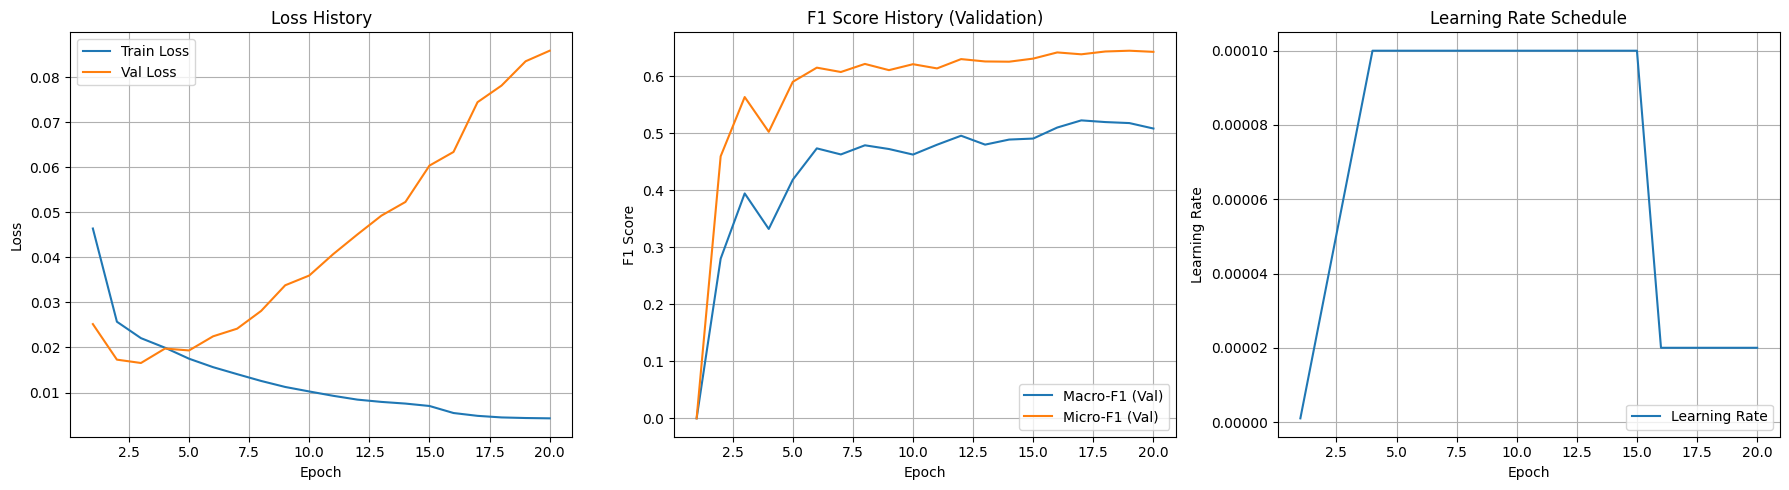

In [ ]:

def train_epoch(model, data_loader, criterion, optimizer, device, epoch, total_epochs, warmup_epochs, initial_lr_factor, target_lr, label_smoothing_epsilon=0.0):
    model.train()
    epoch_loss = 0
    num_batches = len(data_loader)
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    if epoch < warmup_epochs:
        current_lr = target_lr * (initial_lr_factor + (1 - initial_lr_factor) * (epoch / warmup_epochs))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    elif epoch == warmup_epochs:
         for param_group in optimizer.param_groups:
            param_group['lr'] = target_lr

    current_lr_for_log = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} - Current Learning Rate: {current_lr_for_log:.2e}")


    for batch_idx, batch in enumerate(progress_bar):
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        if label_smoothing_epsilon > 0.0:
            smoothed_labels = labels * (1.0 - label_smoothing_epsilon) + label_smoothing_epsilon * (1.0 - labels)
        else:
            smoothed_labels = labels

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, smoothed_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f} ({epoch_loss/(batch_idx+1):.4f} avg)', 'lr': f'{current_lr_for_log:.2e}'})

    return epoch_loss / num_batches

def evaluate_epoch(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_true = []
    num_batches = len(data_loader)
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch_idx, batch in enumerate(progress_bar):
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(labels.cpu().numpy())
            progress_bar.set_postfix({'loss': f'{loss.item():.4f} ({epoch_loss/(batch_idx+1):.4f} avg)'})

    avg_loss = epoch_loss / num_batches
    all_preds_np = np.array(all_preds)
    all_true_np = np.array(all_true)

    if all_preds_np.size == 0 or all_true_np.size == 0:
        print("Warning: No predictions or true labels collected. Metrics will be zero.")
        macro_f1 = 0.0
        micro_f1 = 0.0
    else:
        macro_f1 = f1_score(all_true_np, all_preds_np, average='macro', zero_division=0)
        micro_f1 = f1_score(all_true_np, all_preds_np, average='micro', zero_division=0)

    return avg_loss, macro_f1, micro_f1


best_macro_f1 = 0.0
history = {'train_loss': [], 'val_loss': [], 'macro_f1': [], 'micro_f1': [], 'lr': []}

if not ('train_loader' in locals() and 'val_loader' in locals() and len(train_dataset) > 0 and len(val_dataset) > 0):
    print("Training or validation dataset/loader is empty or not defined. Skipping training loop.")
else:
    print(f"\nStarting training for {NUM_EPOCHS} epochs ({WARMUP_EPOCHS} warmup epochs)...")

    
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

        train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE,
                                 epoch, NUM_EPOCHS, WARMUP_EPOCHS, INITIAL_LR_RATIO, LEARNING_RATE,
                                 LABEL_SMOOTHING_EPSILON)
        val_loss, macro_f1, micro_f1 = evaluate_epoch(model, val_loader, criterion, DEVICE)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['macro_f1'].append(macro_f1)
        history['micro_f1'].append(micro_f1)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(f"Epoch {epoch+1} Summary:")
        print(f"\tTrain Loss: {train_loss:.4f}")
        print(f"\tVal Loss  : {val_loss:.4f}")
        print(f"\tMacro-F1: {macro_f1:.4f}")
        print(f"\tMicro-F1: {micro_f1:.4f}")

        if epoch >= WARMUP_EPOCHS:
            scheduler.step(macro_f1)
        else:
            print(f"\tIn warmup phase, LR managed by warmup logic. Main scheduler active from epoch {WARMUP_EPOCHS + 1}.")


        early_stopping(macro_f1, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            print(f"\tNew best model based on epoch Macro-F1: {best_macro_f1:.4f} (saved by EarlyStopping if improved)")


    print("\nTraining finished.")
    print(f"Best Validation Macro-F1 during training: {early_stopping.best_score:.4f} (model saved as '{early_stopping.path}')")

    if NUM_EPOCHS > 0 and len(history['train_loss']) > 0 :
        epochs_ran = len(history['train_loss'])
        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.plot(range(1, epochs_ran + 1), history['train_loss'], label='Train Loss')
        plt.plot(range(1, epochs_ran + 1), history['val_loss'], label='Val Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.plot(range(1, epochs_ran + 1), history['macro_f1'], label='Macro-F1 (Val)')
        plt.plot(range(1, epochs_ran + 1), history['micro_f1'], label='Micro-F1 (Val)')
        plt.title('F1 Score History (Validation)')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 3, 3)
        plt.plot(range(1, epochs_ran + 1), history['lr'], label='Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()